## **Practical No 3:Twitter Sentiment Analysis**

<div class="alert alert-block alert-danger">  
<h2><center><strong>Import Libraries</strong></center></h2>
        
</div>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<div class="alert alert-block alert-danger">  
<h2><center><strong>Loading the data</strong></center></h2>
        
</div>

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/BigDataAnalytics/Practical3/train_1600000.csv", encoding = "ISO-8859-1", engine="python")
data.columns = ["label", "time", "date", "query", "username", "text"]

<div class="alert alert-block alert-danger">  
<h2><center><strong>Exploratory data analysis</strong></center></h2>
        
</div>

#### Five top records of data

In [ ]:
data.head()

,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


#### Five last records of data

In [ ]:
data.tail()

,label,time,date,query,username,text
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599998,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


#### Coloumns/features in data

In [ ]:
data.columns

Index(['label', 'time', 'date', 'query', 'username', 'text'], dtype='object')

#### Length of data

In [ ]:
print('lenght of data is', len(data))

lenght of data is 1599999


#### Shape of data

In [ ]:
data.shape

(1599999, 6)

#### Data information

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1599999 non-null  int64 
 1   time      1599999 non-null  int64 
 2   date      1599999 non-null  object
 3   query     1599999 non-null  object
 4   username  1599999 non-null  object
 5   text      1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


#### Data types of all coloumns

In [ ]:
data.dtypes

label        int64
time         int64
date        object
query       object
username    object
text        object
dtype: object

#### Checking Null values

In [ ]:
np.sum(data.isnull().any(axis=1))

0

#### Rows and columns in the dataset

In [ ]:
print('Count of columns in the data is:  ', len(data.columns))

Count of columns in the data is:   6


In [ ]:
print('Count of rows in the data is:  ', len(data))

Count of rows in the data is:   1599999


<div class="alert alert-block alert-danger">  
<h1><center><strong>Data Preparation</strong></center></h1>

#### Selecting the text and label coloumn

In [ ]:
data=data[['text','label']]

#### Assigning 1 to Positive sentment 4

In [ ]:
data['label'][data['label']==4]=1

#### Separating positive and negative tweets

In [ ]:
data_pos = data[data['label'] == 1]
data_neg = data[data['label'] == 0]

#### taking one fourth data so we can run on our machine easily

In [ ]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

#### Combining positive and negative tweets

In [ ]:
data = pd.concat([data_pos, data_neg])

#### Making statement text in lower case

In [ ]:
data['text']=data['text'].str.lower()

In [ ]:
data['text'].tail()

19995                            one more day of holidays 
19996    feeling so down right now .. i hate you damn h...
19997    geez,i hv to read the whole book of personalit...
19998    i threw my sign at donnie and he bent over to ...
19999    @heather2711 good thing i didn't find any then...
Name: text, dtype: object

#### Cleaning and removing Stop words of english

In [ ]:
import nltk
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

#### Cleaning and removing the above stop words list from the tweet text

In [ ]:
STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()

799999                love @health4uandpets u guys r best!!
800000    im meeting one besties tonight! cant wait!! - ...
800001    @darealsunisakim thanks twitter add, sunisa! g...
800002    sick really cheap hurts much eat real food plu...
800003                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

#### Cleaning and removing punctuations

In [ ]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [ ]:
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text'].tail()

19995                                     one day holidays
19996                     feeling right  hate damn humprey
19997    geezi hv read whole book personality types emb...
19998     threw sign donnie bent get thingee made sad face
19999    heather2711 good thing find none ones like com...
Name: text, dtype: object

#### Cleaning and removing repeating characters

In [ ]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [ ]:
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

#### Cleaning and removing email

In [ ]:
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)

In [ ]:
data['text']= data['text'].apply(lambda x: cleaning_email(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

#### Cleaning and removing URL's

In [ ]:
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

In [ ]:
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

#### Cleaning and removing Numeric numbers

In [ ]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

In [ ]:
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather god thing find none ones like come siz...
Name: text, dtype: object

#### Getting tokenization of tweet text

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
data['text'] = data['text'].apply(tokenizer.tokenize)

In [ ]:
data['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

#### Applying Stemming

In [ ]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

data['text']= data['text'].apply(lambda x: stemming_on_text(x))

In [ ]:
data['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

#### Applying Lemmatizer

In [ ]:
lm = nltk.WordNetLemmatizer()
nltk.download('wordnet')
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
data['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

####  Separating input feature and label

In [ ]:
X=data.text
y=data.label

#### Preparing the input features for training
- We converting the text words into arrays form.
- Maximum 500 features/words selected for training. These 500 words will be selected on the importance that will distinguish between the positive tweets and negative tweets.

In [ ]:
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

As we can see that there total 40000 tweets and the number words/features are 500.

In [ ]:
sequences_matrix.shape

(40000, 500)

#### Separating the 70% data for training data and 30% for testing data

As we prepared all the tweets, now we are separating/splitting the tweets into training data and testing data.
- 70% tweets will be used in the training
- 30% tweets will be used to test the performance of the model.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

<div class="alert alert-block alert-danger">  
<h2><center><strong>Implementing Tensorflow based model for training 🧪</strong></center></h2>   
</div>

In [ ]:
def tensorflow_based_model(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=[max_len])#step1
    layer = Embedding(2000,50,input_length=max_len)(inputs) #step2
    layer = LSTM(64)(layer) #step3
    layer = Dense(256,name='FC1')(layer) #step4
    layer = Activation('relu')(layer) # step5
    layer = Dropout(0.5)(layer) # step6
    layer = Dense(1,name='out_layer')(layer) #step4 again but this time its giving only one output as because we need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer) #step5 but this time activation function is sigmoid for only one output.
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

# Model compilation

- First we are calling the model
- We are using 2 classes so we set "binary_crossentropy" and if we use more than two classes then we use "categorical_crossentropy"
- Optimizer is a function that used to change the features of neural network such as learning rate (how the model learn with features) in order to reduce the losses. So the learning rate of neural network to reduce the losses is defined by optimizer.
- We are setting metrics=accuracy because we are going to caluclate the percentage of correct predictions over all predictions on the validation set

In [ ]:
model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

#### Training and validating with parameter tuning
- We are feeding the training data and getting 10% data for validation from training data
* We set the following parameters:
- Batch size =80 so the model take 80 tweets in each iteration and train them. Batch size is a term used in machine learning and refers to the number of training examples utilized in one iteration.
- Epochs =6 so the model will train on the data 6 times.Epoch is a term used in machine learning and indicates the number of passes of the entire training dataset the machine learning algorithm has completed.
- We can choose batch_size, and epochs as we want so the good practice is to set some values and train the model if the model will not give the good results we can change it and then try again for the training of the model. We can repeat this process many time untill we will not get the good results and this process called as parameter tuning.


In [ ]:
history=model.fit(X_train,Y_train,batch_size=80,epochs=6, validation_split=0.1)# here we are starting the training of model by feeding the training data
print('Training finished !!')

Epoch 1/6
315/315 [==============================] - 146s 457ms/step - loss: 0.6094 - accuracy: 0.6544 - val_loss: 0.5414 - val_accuracy: 0.7246
Epoch 2/6
315/315 [==============================] - 135s 427ms/step - loss: 0.5137 - accuracy: 0.7518 - val_loss: 0.5192 - val_accuracy: 0.7443
Epoch 3/6
315/315 [==============================] - 132s 419ms/step - loss: 0.5254 - accuracy: 0.7434 - val_loss: 0.5532 - val_accuracy: 0.7129
Epoch 4/6
315/315 [==============================] - 134s 425ms/step - loss: 0.4929 - accuracy: 0.7640 - val_loss: 0.5178 - val_accuracy: 0.7375
Epoch 5/6
315/315 [==============================] - 138s 438ms/step - loss: 0.4801 - accuracy: 0.7730 - val_loss: 0.5156 - val_accuracy: 0.7439
Epoch 6/6
315/315 [==============================] - 134s 427ms/step - loss: 0.4686 - accuracy: 0.7767 - val_loss: 0.5313 - val_accuracy: 0.7414
Training finished !!


<h1> We need to do all the above configurations to train the model. If we will not set all settings correctly then we could not get the desired results.</h1>

#### Testing the Trained model on test data
- Getting predictions/classifying the sentiments (positve/negative) on the test data using trained model.

In [ ]:
accr1 = model.evaluate(X_test,Y_test) #we are starting to test the model here

375/375 [==============================] - 28s 74ms/step - loss: 0.5257 - accuracy: 0.7440


#### Accuracy
- Accuracy is the number of correctly classify tweets from all the tweets of positive and negative.
- For example, if the trained model classify the 70 tweets correct and 30 tweets wrong from total of 100 tweets then the accuracy score will be 70%.
- Accuracy= Total number of correct predictions/Total number of predictions

In [ ]:
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1])) #the accuracy of the model on test data is given below

Test set
  Accuracy: 0.74


#### Getting prediction of the test data and then we will compare the true labels/classes of the data with predictions
- As the model give probabilties so we are setting a threshold 0.5. More than 0.5 will be the positive tweets and lower will be negative tweets

In [ ]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5)

375/375 [==============================] - 28s 74ms/step


#### Confusion matrix
- These are the evaluation measures to evaluate the performance of the model.
- Dark blue boxes are the correct predictions with the trained model and sky blue boxes shows the wrong predictions.
- 4610 tweets correctly predicted as negative sentiments. 1399 tweets predicted positive sentiments but that were actually negative sentiments.
- 4247 tweets correctly predicted as postive sentiments. 1744 tweets predicted negative sentiments but that were actually positive sentiments.



confusion matrix


[[4519 1490]
 [1582 4409]]




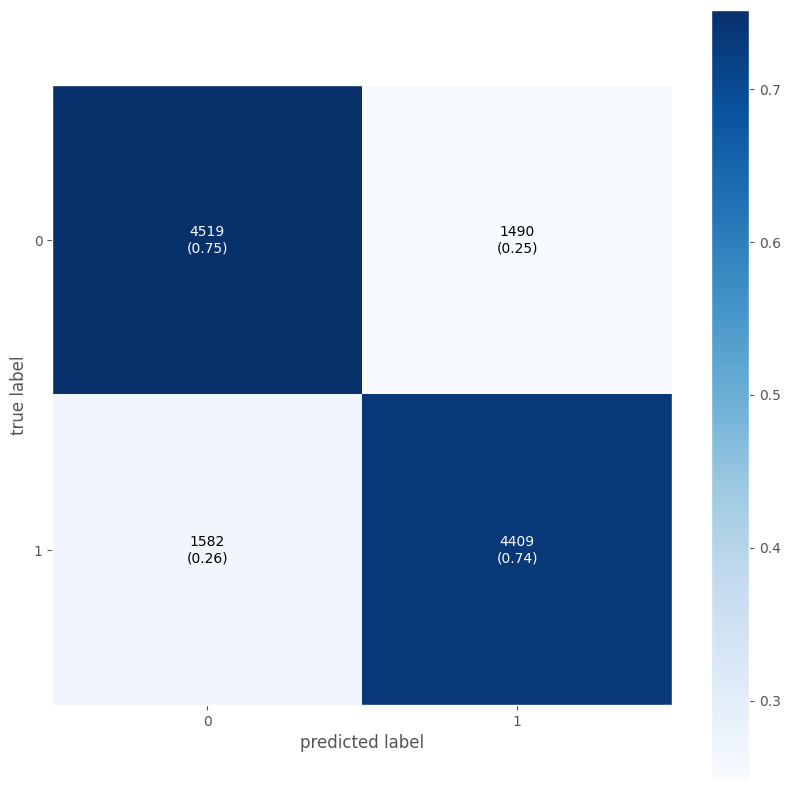

In [ ]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

# ROC CURVE
- ROC curve show the performance of the model as well.
- We can see that the model started from the 0 percent predictions and then moved to true positive predictions that are correct
- ROC curve (receiver operating characteristic curve) show the performance of a classification model at all the classification thresholds. ROC plots two parameters, True Positive Rate (correct predictions/classifications) False Positive Rate (wrong predictions/classifications)

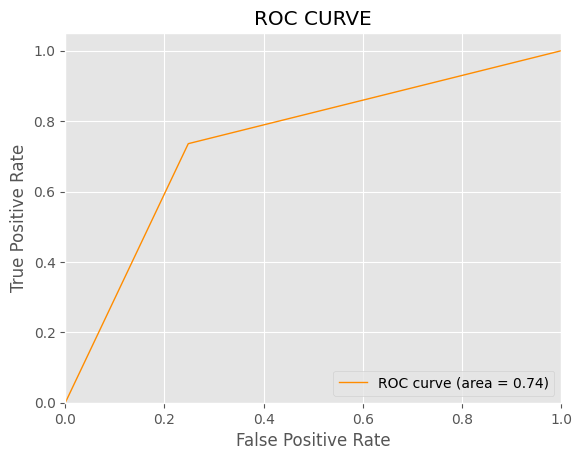

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

<div class="alert alert-block alert-success">  
<h1><center><strong>Conclusion</strong></center></h1>
    <p>
<li>We used the twitter sentiment analysis dataset and explored the data with different ways.</li>
        <li>We prepared the text data of tweets by removing the unnecessary things.</li>
          <li>We trained model based on tensorflow with all settings. </li>
        <li>We evaluated thye model with different evaluation measures.</li>
         <li>If you are interested to work on any text based project, you can simply apply the same methodolgy but might be you will need to change little settings like name of coloumns etc.</li>
        <li>We worked on the classification problem and sepcifically we call it binary classification which is two class classification.</li>
        </p>
</div>